# Drug Repositioning Predictions by Non-Negative Matrix Tri-Factorization of Integrated Association Data

This notebook aims at computing and showing results obtained recently.
They have been more precisely explained in a recently-submitted paper.

This notebook contains a lot of information and work and tries to sum it up. After some preliminary work (transforming the data to fit the method we use), we describe the different optimizations made on the method and then we show the main results.

This notebook is divided into 7 sections:
1. Data and Association Matrices
2. Mask Matrix
3. Initialization
4. Hyperparameters
5. Stop Criterion
6. Improvements
7. Final Results

In [1]:
#First we load the packages we need
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from scipy import sparse
import seaborn as sns
import pandas as pd
import numpy as np
import csv

#These two classes are implemented in the repository
from load_data_NMTF import loader
from method_NMTF import NMTF

#While using a server to run this notebook, it can be necessary to limit the number of threads
import os
os.environ["MKL_NUM_THREADS"] = "5"
os.environ["NUMEXPR_NUM_THREADS"] = "5"
os.environ["OMP_NUM_THREADS"] = "5"
os.environ["OPENBLAS_NUM_THREADS"] = "5"
os.environ["VECLIB_MAXIMUM_THREADS"] = "5"

## 1. Data and Association Matrices

The data is provided in different heterogeneous files. We first have to load these different files to create and save the matrices we need and that include all the data.

Initially, the data is stored in heterogeneous files (in the _data_ folder):
- **_Drugs.txt_** lists all drug IDs;
- **_LabelsDrugs.txt_** lists all links between labels (indications) and drugs, providing label names, drug names and drug IDs;
- **_Proteins.txt_** lists all protein IDs;
- **_Pathways.txt_** lists all pathway IDs;
- **_network.txt_** lists all inter-associations between drugs and proteins, and proteins and pathways;
- **_ProteinsToProteins.txt_** lists all intra-links among proteins;
- **_PathwaysToPathways.txt_** lists all intra-links among pathways;
- **_DrugDisease.csv_** lists all inter-associations between drugs and diseases, giving drugs IDs and disease names.

Thanks to these files, we want to get the following matrices:
- __$R_{12}$__ : inter-associations between __labels__ and __drugs__;
- __$R_{23}$__ : inter-associations between __drugs__ and __proteins__;
- __$R_{34}$__ : inter-associations between __proteins__ and __pathways__;
- __$R_{25}$__ : inter-associations between __drugs__ and __diseases__;
- __$W_3$__ : intra-associations among __proteins__;
- __$W_4$__ : intra-associations among __pathways__.

To do so, we use the class implemented in ***load_data_NMTF.py***:

In [2]:
f_drugs = 'Drugs.txt'
f_proteins = 'Proteins.txt'
f_pathways = 'Pathways.txt'
f_labelsdrugs = 'LabelsDrugs.txt'
f_network = 'network.txt'
f_drugsdiseases = 'DrugDisease.csv'
f_protprot = 'ProteinsToProteins.txt'
f_pathpath = 'PathwaysToPathways.txt'

load = loader(f_drugs, f_proteins, f_pathways, f_labelsdrugs, f_network, f_drugsdiseases, f_protprot, f_pathpath)

R12, R23, R34, R25, W3, W4 = load.association_matrices()

We can also already compute $L_3$ and $L_4$, the laplacian matrices associated with $W_3$ and $W_4$ respectively.

In [3]:
d3 = np.array(W3.sum(axis=0))
D3 = sparse.diags(d3[0], 0)
L3 = D3 - W3 #laplacian matrix of intra-protein links

d4 = np.array(W4.sum(axis=0))
D4 = sparse.diags(d4[0], 0)
L4 = D4 - W4 #laplacian matrix of intra-pathway links

And save the results in different files as sparse matrices (which needs way less space than numpy matrices):

In [4]:
#sparse.save_npz('./tmp/R12.npz', R12)
#sparse.save_npz('./tmp/R23.npz', R23)
#sparse.save_npz('./tmp/R34.npz', R34)
#sparse.save_npz('./tmp/R25.npz', R25)
#sparse.save_npz('./tmp/W3.npz', W3)
#sparse.save_npz('./tmp/W4.npz', W4)
#sparse.save_npz('./tmp/L3.npz', L3)
#sparse.save_npz('./tmp/L4.npz', L4)

From now, as we are about to focus on link prediction between labels and drugs, i.e. in $R_{12}$, it is interesting to habe a good understanding of this matrix. The number of drugs associated to one label vary a lot.
While 1 drug is associated to _Increased IgG Production_, 666 drugs are associated to the label _Cytochrome P-450 CYP3A Substrates_. This variance can be better understood thanks to the following plot, where the diseases are ranked according to their degree:

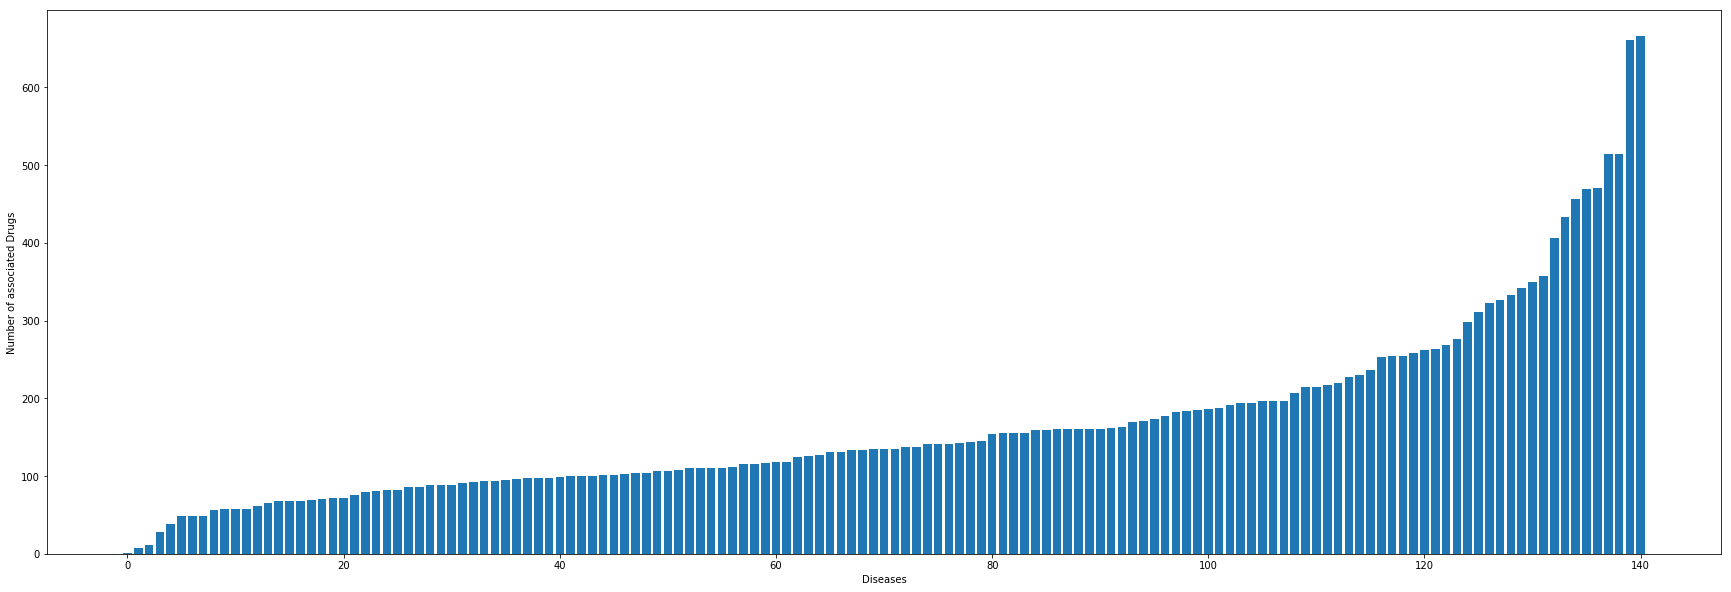

In [5]:
bar = np.sum(R12.toarray(), axis=1)
bar.sort()
X = np.arange(len(bar))
plt.rcParams["figure.figsize"] = (30,10)
plt.bar(X, bar)
plt.xlabel('Diseases')
plt.ylabel('Number of associated Drugs')
plt.show()

Finally, if we want some information about the data:

In [6]:
inter_ld = np.count_nonzero(R12.toarray())
inter_dp = np.count_nonzero(R23.toarray())
inter_pp = np.count_nonzero(R34.toarray())
inter_dd = np.count_nonzero(R25.toarray())
print('There are {} labels, {} drugs, {} proteins, {} pathways and {} diseases'.format(R12.shape[0], R12.shape[1], R23.shape[1], R34.shape[1], R25.shape[1]))
print('There are {} links between labels and drugs'.format(inter_ld))
print('There are {} links between drugs and proteins'.format(inter_dp))
print('There are {} links between proteins and pathways'.format(inter_pp))
print('There are {} links between drugs and diseases'.format(inter_dd))

There are 141 labels, 3261 drugs, 3691 proteins, 1914 pathways and 841 diseases
There are 23517 links between labels and drugs
There are 13433 links between drugs and proteins
There are 28345 links between proteins and pathways
There are 2417 links between drugs and diseases


## 2. Mask Matrix

This step consists in creating a validation set to test our algorithm.
For the sake of simplicity, we will first create a random matrix $M_{10}$ of the same size of $R_{12}$ which contains 10% of null elements and 90% of zeros. The indexes of null elements in this matrix will correspond to the elements of the validation set.

In [7]:
#M10 = np.random.binomial(1, 0.9, size=R12.shape)
#np.save('./tmp/M10', M10)
M10 = np.load('./tmp/M10.npy')

In this notebook, to make things easier, we will use this $M_{10}$ matrix.

Nevertheless, to be more coherent, we could design the validation set a bit differently. Indeed, our problem is to find new links between drugs and labels, given that drugs are already associated to some labels. Then, we should build our validation set so that **every drug in the *training set* is still associated with at least one label**. To create a mask having the same proportion of positive and negatives instances as $M_{10}$ and respecting this rule, we can do as follows:

In [8]:
from math import floor

R12 = sparse.load_npz('./tmp/R12.npz').toarray()
M10_2 = np.ones(R12.shape)
n, m = R12.shape
#We compute manually the number of positive and negative items of our validation set
pos = floor(0.1 * np.count_nonzero(R12)) #2351
neg = floor(0.1 * (n*m - np.count_nonzero(R12))) #43628

p2, n2 = 0, 0

def islinked(R):
    return np.min(np.max(R, axis = 0)) == 1

perm = np.random.permutation(n*m)
index = 0

while p2 < pos:
    i = perm[index] // m
    j = perm[index] % m

    if R12[i, j] == 1 and M10_2[i, j] == 1:
        M10_2[i, j] = 0
        R12_res = np.multiply(M10_2, R12)
        if islinked(R12_res):
            p2 += 1
        else:
            M10_2[i, j] = 1
    index += 1

index = 0
while n2 < neg:
    i = perm[index] // m
    j = perm[index] % m
    
    if R12[i, j] == 0 and M10_2[i, j] == 1:
        M10_2[i, j] = 0
        n2 += 1
    index += 1

#np.save('./tmp/M10_2', M10_2)

In [9]:
#if needed
M10_2 = np.load('./tmp/M10_2.npy')

## 3. Initialization

Now that the data and the validation set are imported and created in a good format, we can start tuning our NMTF model for drug repositioning.
The first step, as defined in the paper, is to study the initialization of the NMTF algorithm. In this section, we compute and compare the NMTF algorithm for 4 different initializations.
- **Random initialization**
- **Random ACOL initialization**
- **K-means initialization**
- **Spherical k-means initialization**

We run the script _initialization.py_ to compute the APS score over 500 iterations for those initializations for a given set of hyperparameters. Then, we save those files and reload them here to plot the following curve.
We compute 5 models for each initialization method to also see the variance of those methods.

In this situation, we naively choose the parameters.

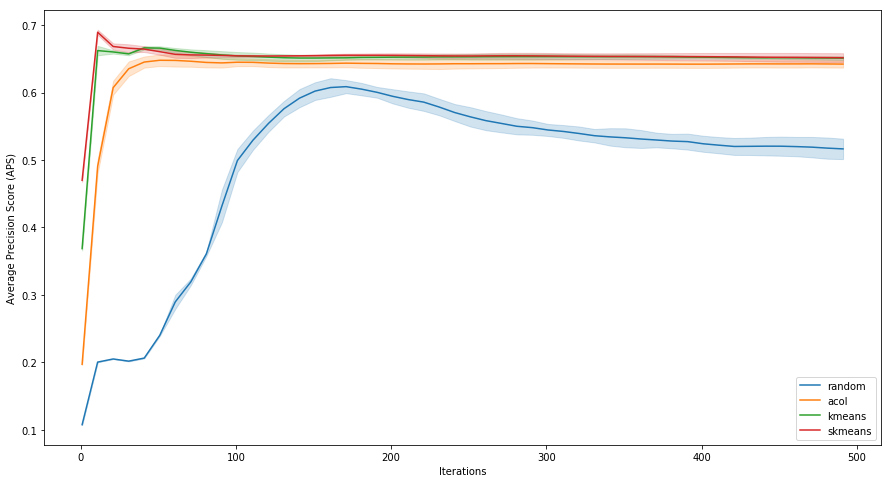

In [4]:
INIT = ['random', 'acol', 'kmeans', 'skmeans']
plt.rcParams["figure.figsize"] = (15,8)

for init in INIT:
    [loss, aps] = np.load('./tmp/initialization_' + init + '.npy')
    X = np.arange(1, 500, 10)
    df = pd.DataFrame(aps, columns = X).melt()
    sns.lineplot(x="variable", y="value", data=df, ci='sd', label = init)

plt.xlabel('Iterations')
plt.ylabel('Average Precision Score (APS)')
plt.show()

## 4. Hyperparameters

By hyperparameters we denote $K = (k_1, k_2, k_3, k_4, k_5) \in N^5$.
We decided to compute the __dispersion coefficient__ as explained in the paper.

Important note: the __dispersion coefficient__ is computed to assess the stability of the results, ie the matrices $R_{12}, R_{23}, R_{34}$ and $R_{25}$.

For instance, as we will see in this example, we will compute $\rho_4$, the dispersion coefficient for $k_4$ on the matrix $R_{34}$ computed by the algorithm. For this application, we will stop the algorithm after 10 iterations, and run 5 times the NMTF algorithm for a given set of parameters.
The script _dispersion4.py_ is run and the results are reloaded here to plot the results.

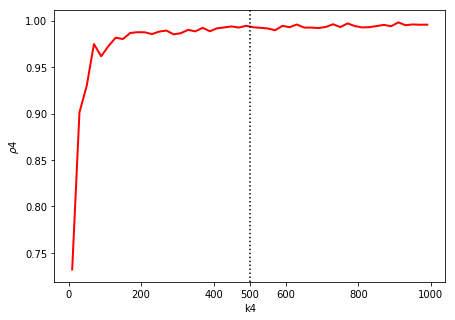

In [6]:
rho4 = np.load('./tmp/rho4.npy')
plt.rcParams["figure.figsize"] = (7,5)
X = np.arange(10, len(rho4)*20 + 1, 20)

plt.plot(X, rho4, color = 'r', linewidth = 2)
plt.axvline(500, linestyle = ':', color = 'black')
plt.xticks([0, 200, 400, 500, 600, 800, 1000])
plt.xlabel('k4')
plt.ylabel('$\\rho$4')

plt.show()

In this plot, $(k_1, k_2, k_3, k_5) = (500, 141, 500, 300)$.

As we can see here, we decided to choose $k_4 = 500$ as a good compromise between the reproductibility of the results and the computation complexity. Finally, we decide to set $ K = (k_1, k_2, k_3, k_4, k_5) = (500, 141, 500, 500, 300)$.

## 5. Stop criterion

Last but not least, we had to find a good stop criterion for our algorithm. Here are the options:
- Stop after a defined and fixed number of iterations;
- Use a stop criterion based on the loss.

As explained in the paper, we decide to use the following stop criterion:

$$\frac{J(\textbf{G}^{(n)}) - J(\textbf{G}^{(n+1)})}{J(\textbf{G}^{(n+1)})} < \epsilon$$

For $\epsilon = 0.02$ we have the following results:

In [12]:
M10 = np.load('./tmp/M10.npy')

epsilon = 2e-2
K = [500, 141, 500, 500, 300]
max_iter = 30
nmtf = NMTF('skmeans', K, M10)
I = max_iter
    
loss, aps = [], []
nmtf.initialize()
loss.append(nmtf.loss())
for p in tqdm_notebook(range(max_iter)):
    nmtf.iterate()
    loss.append(nmtf.loss())
    aps.append(nmtf.validate())
    
            
    CRIT = abs((loss[-1] - loss[-2]) / loss[-1])  
      
    if CRIT < epsilon:
        I = min(I, p + 1)

print(nmtf)


Model NMTF with (k1, k2, k3, k4, k5)=(500, 141, 500, 500, 300) and skmeans initialization


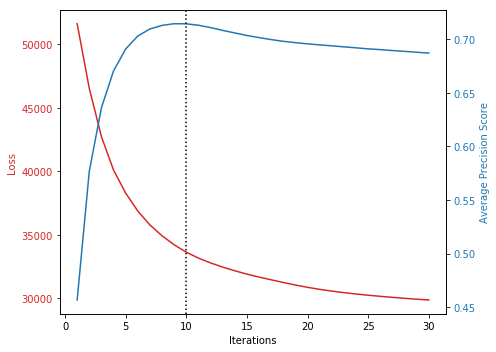

In [13]:
X = np.arange(1, len(loss))         
plt.rcParams["figure.figsize"] = (7,5)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss', color=color)
ax1.plot(X, loss[1:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Average Precision Score', color=color)  # we already handled the x-label with ax1
ax2.plot(X, aps, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.axvline(x=I, color='k', linestyle = ':')

plt.show()

This criterion is particularly relevant because it works with really different sets of parameters.

In [14]:
M10 = np.load('./tmp/M10.npy')

epsilon = 2e-2
K = [100, 100, 100, 100, 300]
max_iter = 50
nmtf2 = NMTF('skmeans', K, M10)
I2 = max_iter
    
loss2, aps2 = [], []
nmtf2.initialize()
loss2.append(nmtf2.loss())
for p in tqdm_notebook(range(max_iter)):
    nmtf2.iterate()
    loss2.append(nmtf2.loss())
    aps2.append(nmtf2.validate())
    
            
    CRIT = abs((loss2[-1] - loss2[-2]) / loss2[-1])  
      
    if CRIT < epsilon:
        I2 = min(I2, p + 1)

print(nmtf2)


Model NMTF with (k1, k2, k3, k4, k5)=(100, 100, 100, 100, 300) and skmeans initialization


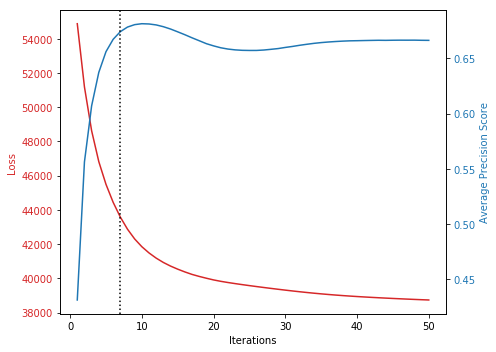

In [15]:
X2 = np.arange(1, len(loss2))         
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss', color=color)
ax1.plot(X2, loss2[1:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Average Precision Score', color=color)  # we already handled the x-label with ax1
ax2.plot(X2, aps2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.axvline(x=I2, color='k', linestyle = ':')

plt.show()

## 6. Improvements

In this section, we will show throught PR-curves plots how we have actually improved the model.
The first interesting thing is to compute the $\hat{R}_{12}$ matrix for different models to show how we improved our method. We compute, with a same mask, the following models in the script _improvements.py_:

| techniques | Skmeans initialization | Good parameters | Stop criterion |
|------------|------------------------|-----------------|----------------|
| Model 1    | -                      | -               | -              |
| Model 2    | ✓                      | -               | -              |
| Model 3    | ✓                      | ✓               | -              |
| Model 4    | ✓                      | ✓               | ✓              |

In [ ]:
plt.rcParams["figure.figsize"] = (7,5)

M10 = np.load('./tmp/M10.npy')
R12 = NMTF.R12
n, m = R12.shape

for i in range(4):
    R12_found = np.load('./tmp/R12_found_' + str(i+1) + '.npy')

    R12_2 = []
    R12_found_2 = []
    for i in range(n):
        for j in range(m):
            if M[i, j] ==  0:
                R12_2.append(R12[i, j])
                R12_found_2.append(R12_found_1[i, j])
    
    
    precision, recall, _ = metrics.precision_recall_curve(R12_2, R12_found_2)
    aps = metrics.average_precision_score(R12_2, R12_found_2)

    plt.plot(recall, precision, label="Model " + str(i+1) +", APS= %0.2f" % aps)

base_precision = np.count_nonzero(R12_2) / len(R12_2)
plt.axhline(base_precision, color='grey', linestyle='dashed', label = "random classifier, APS = %0.2f" % base_precision)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.show()

Also, in order to understand the importance of adding different datasets, we can plot PR curves which corresponds to different $\hat{R}_{12}$  matrices. The datasets used are:
- __Model 1__: $R_{12}$
- __Model 2__: $R_{12}, R_{23}$
- __Model 3__: $R_{12}, R_{23}, R_{34}$
- __Model 4__: $R_{12}, R_{23}, R_{34}, W_3, W_4$
- __Model 5__: $R_{12}, R_{23}, R_{34}, W_3, W_4, R_{25}$

For that, we created new classes in the file *method_NMTF_DatasetContribution.py* and run the script *DatasetContribution.py*. The results are saved and reloaded here in order to display the following plot.

We choose the final hyperparameters : $(k_1, k_2, k_3, k_4, k_5) = (500, 141, 500, 500, 300)$.

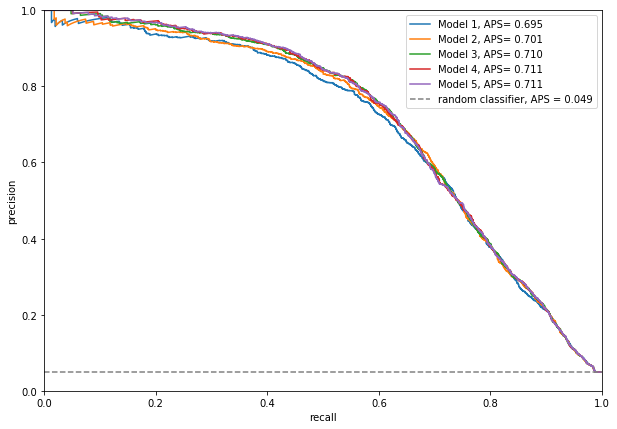

In [16]:
plt.rcParams["figure.figsize"] = (10,7)

M10 = np.load('./tmp/M10.npy')
R12 = NMTF.R12
n, m = R12.shape

for p in range(5):
    R12_found = np.load('./tmp/R12_found_model' + str(p+1) + '_dataset.npy')

    R12_2 = []
    R12_found_2 = []
    for i in range(n):
        for j in range(m):
            if M10[i, j] ==  0:
                R12_2.append(R12[i, j])
                R12_found_2.append(R12_found[i, j])
    
    
    precision, recall, _ = metrics.precision_recall_curve(R12_2, R12_found_2)
    aps = metrics.average_precision_score(R12_2, R12_found_2)

    plt.plot(recall, precision, label="Model " + str(p+1) +", APS= %0.3f" % aps)

base_precision = np.count_nonzero(R12_2) / len(R12_2)
plt.axhline(base_precision, color='grey', linestyle='dashed', label = "random classifier, APS = %0.3f" % base_precision)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.show()

## 7. Final Results

In this section, we will briefly explore the final results provided by our method.
We will first apply the NMTF method to all our data, with the best hyperparameters and optimizations discussed.
Running the following code, we compute and save the matrices $\hat{R}_{12}$ and $\hat{R}_{25}$ that we will use as results.

In [17]:
n, m = NMTF.R12.shape
M = np.ones((n, m))
K = [500, 141, 500, 500, 300]

nmtf_final = NMTF('skmeans', K, M)
J = []
epsilon = 2e-2

nmtf_final.initialize()
J.append(nmtf_final.loss())

for i in range(30):
    nmtf_final.iterate()
    J.append(nmtf_final.loss())
    
    if ((J[-2] - J[-1]) / J[-1]) < epsilon:
        break
        
#np.save('./tmp/R12_final', np.linalg.multi_dot([nmtf_final.G1, nmtf_final.S12, nmtf_final.G2.transpose()]))
#np.save('./tmp/R25_final', np.linalg.multi_dot([nmtf_final.G2, nmtf_final.S25, nmtf_final.G5.transpose()]))

Now that this matrices are saved, we will use them to plot the following results. We first load the results and also the names of drugs, labels and diseases corresponding the the different axis of the matrices $\hat{R}_{12}$ and $\hat{R}_{25}$.

In [18]:
R12 = sparse.load_npz('./tmp/R12.npz').toarray()
R25 = sparse.load_npz('./tmp/R25.npz').toarray()

R12_found = np.load('./tmp/R12_final.npy')
R25_found = np.load('./tmp/R25_final.npy')

n1, m1 = R12.shape
n2, m2 = R25.shape

new_links_R12 = np.multiply(np.ones((n1, m1)) - R12, R12_found)
new_links_R25 = np.multiply(np.ones((n2, m2)) - R25, R25_found)

with open('./data/Drugs.txt', "r") as d:
    reader = csv.reader(d)
    dr = list(reader)

drugs = [element[0] for element in dr] #drugs is the list of drug labels
n_drugs = len(drugs)
d.close()

with open('./data/DrugDisease.csv', "r") as d:
    d.readline()
    reader = csv.reader(d)
    diseases = []
    edgesdd = []
    for row in reader:
        dd = row[0].split(';')
        diseases.append(dd[1].lstrip())
        edgesdd.append((dd[0], dd[1].lstrip()))

diseases = list(set(diseases))
diseases.sort()
diseases.pop()
n_diseases = len(diseases)
d.close()

with open('./data/LabelsDrugs.txt', "r") as f:
    f.readline()
    LabelToDrug = [element.split('\t') for element in f.readlines()]
    labels = [i[2][:-1] for i in LabelToDrug if i[0] in drugs]
    drugnames_l = [i[1] for i in LabelToDrug if i[0] in drugs]

drugnames = []

for i in range(len(drugs)):
    drug = drugs[i]
    for l in LabelToDrug:
        if l[0] == drug:
            drugnames.append(l[1])
            break


labels = list(set(labels))
labels.sort() #labels is a list of disease labels, sorted in the alphabetical order
n_labels = len(labels)

The next few lines create a table in which every new links are describes by their *Drug ID*, *Drug Name*, *Label* and *Score*. The *Score* corresponds to the coefficient found in the new computed matrix (through the NMTF method). Here, we only plot the first 100 links found in $\hat{R}_{12}$, ordered by their *Score*.

In [19]:
index_new_links_R12 = np.argsort(new_links_R12.flatten())

new_drugs = []
new_labels = []
prob = []
new_drugnames = []
for i in range(1, 101):
    new_drugs.append(drugs[index_new_links_R12[-i] % m1])
    new_labels.append(labels[index_new_links_R12[-i] // m1])
    prob.append(new_links_R12[index_new_links_R12[-i] // m1, index_new_links_R12[-i] % m1])
    new_drugnames.append(drugnames[index_new_links_R12[-i] % m1])

In [20]:
from IPython.display import Markdown

table = [[i+1, new_drugs[i], new_drugnames[i], new_labels[i], "%.2f" % prob[i]] for i in range(len(prob))]
table.insert(0, ["ID", "Drug ID", "Drug name", "Label", "Score"])

html = ["<table>"]
for row in table:
    html.append("<tr>")
            
    for col in row:
        html.append("<td>{0}</td>".format(col))
            
    html.append("</tr>")
html.append("</table>")

Markdown(''.join(html))

<table><tr><td>ID</td><td>Drug ID</td><td>Drug name</td><td>Label</td><td>Score</td></tr><tr><td>1</td><td>DB12010</td><td>Fostamatinib</td><td>Cardiovascular Agents</td><td>3.37</td></tr><tr><td>2</td><td>DB14533</td><td>Zinc chloride</td><td>Alcohols</td><td>1.43</td></tr><tr><td>3</td><td>DB00628</td><td>Clorazepate</td><td>Nervous System</td><td>1.11</td></tr><tr><td>4</td><td>DB01224</td><td>Quetiapine</td><td>Neurotransmitter Agents</td><td>1.06</td></tr><tr><td>5</td><td>DB00659</td><td>Acamprosate</td><td>Central Nervous System Depressants</td><td>1.06</td></tr><tr><td>6</td><td>DB01238</td><td>Aripiprazole</td><td>Neurotransmitter Agents</td><td>1.04</td></tr><tr><td>7</td><td>DB12267</td><td>Brigatinib</td><td>Cytochrome P-450 Enzyme Inducers</td><td>0.98</td></tr><tr><td>8</td><td>DB14185</td><td>Aripiprazole lauroxil</td><td>Neurotransmitter Agents</td><td>0.92</td></tr><tr><td>9</td><td>DB12010</td><td>Fostamatinib</td><td>Antiarrhythmic agents</td><td>0.91</td></tr><tr><td>10</td><td>DB00825</td><td>Levomenthol</td><td>Cardiovascular Agents</td><td>0.91</td></tr><tr><td>11</td><td>DB13961</td><td>Fish oil</td><td>Cardiovascular Agents</td><td>0.90</td></tr><tr><td>12</td><td>DB13746</td><td>Bioallethrin</td><td>Membrane Transport Modulators</td><td>0.89</td></tr><tr><td>13</td><td>DB00005</td><td>Etanercept</td><td>Antineoplastic and Immunomodulating Agents</td><td>0.88</td></tr><tr><td>14</td><td>DB04855</td><td>Dronedarone</td><td>Agents causing hyperkalemia</td><td>0.88</td></tr><tr><td>15</td><td>DB14724</td><td>Emapalumab</td><td>Blood Proteins</td><td>0.87</td></tr><tr><td>16</td><td>DB00157</td><td>NADH</td><td>Biological Factors</td><td>0.87</td></tr><tr><td>17</td><td>DB00825</td><td>Levomenthol</td><td>Membrane Transport Modulators</td><td>0.87</td></tr><tr><td>18</td><td>DB11855</td><td>Revefenacin</td><td>Agents producing tachycardia</td><td>0.87</td></tr><tr><td>19</td><td>DB00313</td><td>Valproic Acid</td><td>Cytochrome P-450 CYP3A4 Substrates</td><td>0.86</td></tr><tr><td>20</td><td>DB00754</td><td>Ethotoin</td><td>Cytochrome P-450 Enzyme Inducers</td><td>0.86</td></tr><tr><td>21</td><td>DB11181</td><td>Homatropine</td><td>Agents producing tachycardia</td><td>0.85</td></tr><tr><td>22</td><td>DB08827</td><td>Lomitapide</td><td>Cytochrome P-450 Enzyme Inhibitors</td><td>0.85</td></tr><tr><td>23</td><td>DB06216</td><td>Asenapine</td><td>Neurotransmitter Agents</td><td>0.84</td></tr><tr><td>24</td><td>DB12130</td><td>Lorlatinib</td><td>Cytochrome P-450 CYP3A4 Inducers</td><td>0.83</td></tr><tr><td>25</td><td>DB00246</td><td>Ziprasidone</td><td>Agents producing tachycardia</td><td>0.83</td></tr><tr><td>26</td><td>DB00809</td><td>Tropicamide</td><td>Agents producing tachycardia</td><td>0.83</td></tr><tr><td>27</td><td>DB06579</td><td>Adipiplon</td><td>Nervous System</td><td>0.82</td></tr><tr><td>28</td><td>DB00453</td><td>Clomocycline</td><td>Anti-Infective Agents</td><td>0.82</td></tr><tr><td>29</td><td>DB14533</td><td>Zinc chloride</td><td>Carbohydrates</td><td>0.82</td></tr><tr><td>30</td><td>DB01186</td><td>Pergolide</td><td>Central Nervous System Agents</td><td>0.82</td></tr><tr><td>31</td><td>DB01159</td><td>Halothane</td><td>Psycholeptics</td><td>0.81</td></tr><tr><td>32</td><td>DB01068</td><td>Clonazepam</td><td>Psycholeptics</td><td>0.81</td></tr><tr><td>33</td><td>DB04855</td><td>Dronedarone</td><td>Membrane Transport Modulators</td><td>0.81</td></tr><tr><td>34</td><td>DB12010</td><td>Fostamatinib</td><td>Bradycardia-Causing Agents</td><td>0.80</td></tr><tr><td>35</td><td>DB00594</td><td>Amiloride</td><td>Antihypertensive Agents</td><td>0.80</td></tr><tr><td>36</td><td>DB11737</td><td>Icotinib</td><td>Cytochrome P-450 CYP3A4 Inducers</td><td>0.80</td></tr><tr><td>37</td><td>DB01200</td><td>Bromocriptine</td><td>Serotonergic Drugs Shown to Increase Risk of Serotonin Syndrome</td><td>0.78</td></tr><tr><td>38</td><td>DB00363</td><td>Clozapine</td><td>Serotonergic Drugs Shown to Increase Risk of Serotonin Syndrome</td><td>0.78</td></tr><tr><td>39</td><td>DB13961</td><td>Fish oil</td><td>Membrane Transport Modulators</td><td>0.78</td></tr><tr><td>40</td><td>DB00521</td><td>Carteolol</td><td>Agents that produce hypertension</td><td>0.78</td></tr><tr><td>41</td><td>DB01214</td><td>Metipranolol</td><td>Agents that produce hypertension</td><td>0.78</td></tr><tr><td>42</td><td>DB00292</td><td>Etomidate</td><td>Psycholeptics</td><td>0.78</td></tr><tr><td>43</td><td>DB04821</td><td>Nomifensine</td><td>Antiarrhythmic agents</td><td>0.77</td></tr><tr><td>44</td><td>DB06101</td><td>IMC-1C11</td><td>Antibodies</td><td>0.77</td></tr><tr><td>45</td><td>DB05276</td><td>Hepatitis B Immune Globulin</td><td>Antibodies</td><td>0.76</td></tr><tr><td>46</td><td>DB05915</td><td>MYO-029</td><td>Antibodies</td><td>0.76</td></tr><tr><td>47</td><td>DB11582</td><td>Thiocolchicoside</td><td>Central Nervous System Agents</td><td>0.76</td></tr><tr><td>48</td><td>DB00342</td><td>Terfenadine</td><td>Agents producing tachycardia</td><td>0.76</td></tr><tr><td>49</td><td>DB00845</td><td>Clofazimine</td><td>Cytochrome P-450 Enzyme Inhibitors</td><td>0.76</td></tr><tr><td>50</td><td>DB14185</td><td>Aripiprazole lauroxil</td><td>Nervous System</td><td>0.76</td></tr><tr><td>51</td><td>DB01281</td><td>Abatacept</td><td>Immunoglobulins</td><td>0.76</td></tr><tr><td>52</td><td>DB01028</td><td>Methoxyflurane</td><td>Psycholeptics</td><td>0.76</td></tr><tr><td>53</td><td>DB09026</td><td>Aliskiren</td><td>Cardiovascular Agents</td><td>0.76</td></tr><tr><td>54</td><td>DB00628</td><td>Clorazepate</td><td>Serotonergic Drugs Shown to Increase Risk of Serotonin Syndrome</td><td>0.75</td></tr><tr><td>55</td><td>DB06681</td><td>Belatacept</td><td>Immunoglobulins</td><td>0.75</td></tr><tr><td>56</td><td>DB00852</td><td>Pseudoephedrine</td><td>Neurotransmitter Agents</td><td>0.75</td></tr><tr><td>57</td><td>DB01189</td><td>Desflurane</td><td>Psycholeptics</td><td>0.75</td></tr><tr><td>58</td><td>DB01068</td><td>Clonazepam</td><td>Psychotropic Drugs</td><td>0.75</td></tr><tr><td>59</td><td>DB01159</td><td>Halothane</td><td>Psychotropic Drugs</td><td>0.74</td></tr><tr><td>60</td><td>DB06081</td><td>Caplacizumab</td><td>Antibodies</td><td>0.74</td></tr><tr><td>61</td><td>DB01236</td><td>Sevoflurane</td><td>Psycholeptics</td><td>0.74</td></tr><tr><td>62</td><td>DB00384</td><td>Triamterene</td><td>Antihypertensive Agents</td><td>0.73</td></tr><tr><td>63</td><td>DB00739</td><td>Hetacillin</td><td>Anti-Bacterial Agents</td><td>0.73</td></tr><tr><td>64</td><td>DB11367</td><td>Cefroxadine</td><td>Anti-Infective Agents</td><td>0.73</td></tr><tr><td>65</td><td>DB14489</td><td>Ferrous succinate</td><td>Hematologic Agents</td><td>0.73</td></tr><tr><td>66</td><td>DB14501</td><td>Ferrous glycine sulfate</td><td>Hematologic Agents</td><td>0.73</td></tr><tr><td>67</td><td>DB00228</td><td>Enflurane</td><td>Psycholeptics</td><td>0.73</td></tr><tr><td>68</td><td>DB12010</td><td>Fostamatinib</td><td>Hypotensive Agents</td><td>0.72</td></tr><tr><td>69</td><td>DB01149</td><td>Nefazodone</td><td>Neurotransmitter Agents</td><td>0.72</td></tr><tr><td>70</td><td>DB09089</td><td>Trimebutine</td><td>Membrane Transport Modulators</td><td>0.71</td></tr><tr><td>71</td><td>DB06204</td><td>Tapentadol</td><td>Central Nervous System Agents</td><td>0.71</td></tr><tr><td>72</td><td>DB00777</td><td>Propiomazine</td><td>Neurotransmitter Agents</td><td>0.71</td></tr><tr><td>73</td><td>DB01028</td><td>Methoxyflurane</td><td>Psychotropic Drugs</td><td>0.71</td></tr><tr><td>74</td><td>DB00334</td><td>Olanzapine</td><td>Cytochrome P-450 CYP3A Substrates</td><td>0.70</td></tr><tr><td>75</td><td>DB00334</td><td>Olanzapine</td><td>Cytochrome P-450 CYP3A4 Substrates</td><td>0.70</td></tr><tr><td>76</td><td>DB00081</td><td>Tositumomab</td><td>Antineoplastic and Immunomodulating Agents</td><td>0.70</td></tr><tr><td>77</td><td>DB00628</td><td>Clorazepate</td><td>Serotonin Agents</td><td>0.70</td></tr><tr><td>78</td><td>DB11753</td><td>Rifamycin</td><td>Cytochrome P-450 CYP3A Substrates</td><td>0.70</td></tr><tr><td>79</td><td>DB00292</td><td>Etomidate</td><td>Psychotropic Drugs</td><td>0.70</td></tr><tr><td>80</td><td>DB00852</td><td>Pseudoephedrine</td><td>Adrenergic Agents</td><td>0.70</td></tr><tr><td>81</td><td>DB00864</td><td>Tacrolimus</td><td>Cytochrome P-450 Enzyme Inhibitors</td><td>0.70</td></tr><tr><td>82</td><td>DB00247</td><td>Methysergide</td><td>Serotonergic Drugs Shown to Increase Risk of Serotonin Syndrome</td><td>0.70</td></tr><tr><td>83</td><td>DB13746</td><td>Bioallethrin</td><td>Cardiovascular Agents</td><td>0.69</td></tr><tr><td>84</td><td>DB09118</td><td>Stiripentol</td><td>Cytochrome P-450 CYP3A Substrates</td><td>0.69</td></tr><tr><td>85</td><td>DB00078</td><td>Ibritumomab tiuxetan</td><td>Antibodies, Monoclonal</td><td>0.69</td></tr><tr><td>86</td><td>DB09118</td><td>Stiripentol</td><td>Cytochrome P-450 CYP3A4 Substrates</td><td>0.69</td></tr><tr><td>87</td><td>DB00805</td><td>Minaprine</td><td>Serotonin Agents</td><td>0.69</td></tr><tr><td>88</td><td>DB11753</td><td>Rifamycin</td><td>Cytochrome P-450 CYP3A4 Substrates</td><td>0.69</td></tr><tr><td>89</td><td>DB04855</td><td>Dronedarone</td><td>Cardiovascular Agents</td><td>0.69</td></tr><tr><td>90</td><td>DB09118</td><td>Stiripentol</td><td>Psycholeptics</td><td>0.69</td></tr><tr><td>91</td><td>DB01571</td><td>3-Methylfentanyl</td><td>Analgesics, Non-Narcotic</td><td>0.69</td></tr><tr><td>92</td><td>DB00228</td><td>Enflurane</td><td>Psychotropic Drugs</td><td>0.69</td></tr><tr><td>93</td><td>DB01049</td><td>Ergoloid mesylate</td><td>Cytochrome P-450 CYP2D6 Substrates</td><td>0.68</td></tr><tr><td>94</td><td>DB09045</td><td>Dulaglutide</td><td>Antibodies</td><td>0.68</td></tr><tr><td>95</td><td>DB01045</td><td>Rifampicin</td><td>Cytochrome P-450 Enzyme Inhibitors</td><td>0.68</td></tr><tr><td>96</td><td>DB00081</td><td>Tositumomab</td><td>Antibodies, Monoclonal</td><td>0.68</td></tr><tr><td>97</td><td>DB01189</td><td>Desflurane</td><td>Psychotropic Drugs</td><td>0.68</td></tr><tr><td>98</td><td>DB00073</td><td>Rituximab</td><td>Antineoplastic and Immunomodulating Agents</td><td>0.68</td></tr><tr><td>99</td><td>DB00268</td><td>Ropinirole</td><td>Psychotropic Drugs</td><td>0.68</td></tr><tr><td>100</td><td>DB01180</td><td>Rescinnamine</td><td>Cardiovascular Agents</td><td>0.68</td></tr></table>

It is also easy to do the same for eventual new links found between diseases and drugs, which are described by $\hat{R}_{25}$.

In [21]:
index_new_links_R25 = np.argsort(new_links_R25.flatten())

new_drugs_2 = []
new_diseases = []
prob_2 = []
new_drugnames_2 = []
for i in range(1, 301):
    new_drugs_2.append(drugs[index_new_links_R25[-i] // m2])
    new_diseases.append(diseases[index_new_links_R25[-i] % m2])
    prob_2.append(new_links_R25[index_new_links_R25[-i] // m2, index_new_links_R25[-i] % m2])
    new_drugnames_2.append(drugnames[index_new_links_R25[-i] // m2])

In [22]:
table2 = [[i+1, new_drugs_2[i], new_drugnames_2[i], new_diseases[i], "%.2f" % prob_2[i]] for i in range(len(prob_2))]
table2.insert(0, ["ID", "Drug ID", "Drug name", "Disease", "Score"])

html2 = ["<table>"]
for row in table2:
    html2.append("<tr>")
            
    for col in row:
        html2.append("<td>{0}</td>".format(col))
            
    html2.append("</tr>")
html2.append("</table>")

Markdown(''.join(html2))

<table><tr><td>ID</td><td>Drug ID</td><td>Drug name</td><td>Disease</td><td>Score</td></tr><tr><td>1</td><td>DB13025</td><td>Tiapride</td><td>Schizophrenia</td><td>1.03</td></tr><tr><td>2</td><td>DB08922</td><td>Perospirone</td><td>Schizophrenia</td><td>0.79</td></tr><tr><td>3</td><td>DB01340</td><td>Cilazapril</td><td>Hypertension</td><td>0.79</td></tr><tr><td>4</td><td>DB00275</td><td>Olmesartan</td><td>Hypertension</td><td>0.74</td></tr><tr><td>5</td><td>DB01415</td><td>Ceftibuten</td><td>Bacterial infections</td><td>0.69</td></tr><tr><td>6</td><td>DB00796</td><td>Candesartan cilexetil</td><td>Hypertension</td><td>0.69</td></tr><tr><td>7</td><td>DB00948</td><td>Mezlocillin</td><td>Bacterial infections</td><td>0.68</td></tr><tr><td>8</td><td>DB00560</td><td>Tigecycline</td><td>Bacterial infections</td><td>0.68</td></tr><tr><td>9</td><td>DB00607</td><td>Nafcillin</td><td>Bacterial infections</td><td>0.67</td></tr><tr><td>10</td><td>DB01139</td><td>Cefapirin</td><td>Bacterial infections</td><td>0.66</td></tr><tr><td>11</td><td>DB00229</td><td>Cefotiam</td><td>Bacterial infections</td><td>0.66</td></tr><tr><td>12</td><td>DB00417</td><td>Phenoxymethylpenicillin</td><td>Bacterial infections</td><td>0.66</td></tr><tr><td>13</td><td>DB01605</td><td>Pivmecillinam</td><td>Bacterial infections</td><td>0.66</td></tr><tr><td>14</td><td>DB09286</td><td>Pipamperone</td><td>Schizophrenia</td><td>0.65</td></tr><tr><td>15</td><td>DB01326</td><td>Cefamandole</td><td>Bacterial infections</td><td>0.65</td></tr><tr><td>16</td><td>DB09242</td><td>Moxonidine</td><td>Hypertension</td><td>0.64</td></tr><tr><td>17</td><td>DB09324</td><td>Sulbactam</td><td>Bacterial infections</td><td>0.63</td></tr><tr><td>18</td><td>DB01301</td><td>Rolitetracycline</td><td>Bacterial infections</td><td>0.62</td></tr><tr><td>19</td><td>DB01112</td><td>Cefuroxime</td><td>Bacterial infections</td><td>0.62</td></tr><tr><td>20</td><td>DB01061</td><td>Azlocillin</td><td>Bacterial infections</td><td>0.62</td></tr><tr><td>21</td><td>DB08795</td><td>Azidocillin</td><td>Bacterial infections</td><td>0.61</td></tr><tr><td>22</td><td>DB00254</td><td>Doxycycline</td><td>Bacterial infections</td><td>0.61</td></tr><tr><td>23</td><td>DB12010</td><td>Fostamatinib</td><td>Angina pectoris</td><td>0.61</td></tr><tr><td>24</td><td>DB08836</td><td>Temocapril</td><td>Hypertension</td><td>0.61</td></tr><tr><td>25</td><td>DB00827</td><td>Cinoxacin</td><td>Bacterial infections</td><td>0.60</td></tr><tr><td>26</td><td>DB14185</td><td>Aripiprazole lauroxil</td><td>Schizophrenia</td><td>0.60</td></tr><tr><td>27</td><td>DB01053</td><td>Benzylpenicillin</td><td>Bacterial infections</td><td>0.60</td></tr><tr><td>28</td><td>DB06211</td><td>Doripenem</td><td>Bacterial infections</td><td>0.59</td></tr><tr><td>29</td><td>DB06077</td><td>Lumateperone</td><td>Schizophrenia</td><td>0.58</td></tr><tr><td>30</td><td>DB00467</td><td>Enoxacin</td><td>Bacterial infections</td><td>0.58</td></tr><tr><td>31</td><td>DB13166</td><td>Zofenopril</td><td>Hypertension</td><td>0.58</td></tr><tr><td>32</td><td>DB03615</td><td>Ribostamycin</td><td>Bacterial infections</td><td>0.57</td></tr><tr><td>33</td><td>DB00487</td><td>Pefloxacin</td><td>Bacterial infections</td><td>0.56</td></tr><tr><td>34</td><td>DB00537</td><td>Ciprofloxacin</td><td>Bacterial infections</td><td>0.55</td></tr><tr><td>35</td><td>DB09050</td><td>Ceftolozane</td><td>Bacterial infections</td><td>0.54</td></tr><tr><td>36</td><td>DB00618</td><td>Demeclocycline</td><td>Bacterial infections</td><td>0.54</td></tr><tr><td>37</td><td>DB01627</td><td>Lincomycin</td><td>Bacterial infections</td><td>0.54</td></tr><tr><td>38</td><td>DB02032</td><td>1-(3-Mercapto-2-Methyl-Propionyl)-Pyrrolidine-2-Carboxylic Acid</td><td>Hypertension</td><td>0.54</td></tr><tr><td>39</td><td>DB12455</td><td>Omadacycline</td><td>Bacterial infections</td><td>0.53</td></tr><tr><td>40</td><td>DB01018</td><td>Guanfacine</td><td>Hypertension</td><td>0.53</td></tr><tr><td>41</td><td>DB02918</td><td>Zardaverine</td><td>Asthma</td><td>0.53</td></tr><tr><td>42</td><td>DB09080</td><td>Olodaterol</td><td>Asthma</td><td>0.53</td></tr><tr><td>43</td><td>DB00801</td><td>Halazepam</td><td>Insomnia</td><td>0.52</td></tr><tr><td>44</td><td>DB00692</td><td>Phentolamine</td><td>Hypertension</td><td>0.52</td></tr><tr><td>45</td><td>DB01588</td><td>Prazepam</td><td>Insomnia</td><td>0.52</td></tr><tr><td>46</td><td>DB00842</td><td>Oxazepam</td><td>Insomnia</td><td>0.52</td></tr><tr><td>47</td><td>DB01558</td><td>Bromazepam</td><td>Insomnia</td><td>0.51</td></tr><tr><td>48</td><td>DB01622</td><td>Thioproperazine</td><td>Schizophrenia</td><td>0.51</td></tr><tr><td>49</td><td>DB00359</td><td>Sulfadiazine</td><td>Bacterial infections</td><td>0.50</td></tr><tr><td>50</td><td>DB01063</td><td>Acetophenazine</td><td>Schizophrenia</td><td>0.50</td></tr><tr><td>51</td><td>DB00263</td><td>Sulfisoxazole</td><td>Bacterial infections</td><td>0.50</td></tr><tr><td>52</td><td>DB01614</td><td>Acepromazine</td><td>Schizophrenia</td><td>0.50</td></tr><tr><td>53</td><td>DB00207</td><td>Azithromycin</td><td>Bacterial infections</td><td>0.49</td></tr><tr><td>54</td><td>DB00683</td><td>Midazolam</td><td>Insomnia</td><td>0.49</td></tr><tr><td>55</td><td>DB00623</td><td>Fluphenazine</td><td>Schizophrenia</td><td>0.49</td></tr><tr><td>56</td><td>DB00231</td><td>Temazepam</td><td>Anxiety disorder</td><td>0.49</td></tr><tr><td>57</td><td>DB00897</td><td>Triazolam</td><td>Anxiety disorder</td><td>0.49</td></tr><tr><td>58</td><td>DB01215</td><td>Estazolam</td><td>Anxiety disorder</td><td>0.49</td></tr><tr><td>59</td><td>DB01595</td><td>Nitrazepam</td><td>Anxiety disorder</td><td>0.49</td></tr><tr><td>60</td><td>DB00690</td><td>Flurazepam</td><td>Anxiety disorder</td><td>0.48</td></tr><tr><td>61</td><td>DB00829</td><td>Diazepam</td><td>Insomnia</td><td>0.48</td></tr><tr><td>62</td><td>DB00226</td><td>Guanadrel</td><td>Hypertension</td><td>0.48</td></tr><tr><td>63</td><td>DB01044</td><td>Gatifloxacin</td><td>Bacterial infections</td><td>0.48</td></tr><tr><td>64</td><td>DB00797</td><td>Tolazoline</td><td>Hypertension</td><td>0.48</td></tr><tr><td>65</td><td>DB00404</td><td>Alprazolam</td><td>Insomnia</td><td>0.48</td></tr><tr><td>66</td><td>DB00371</td><td>Meprobamate</td><td>Insomnia</td><td>0.48</td></tr><tr><td>67</td><td>DB00186</td><td>Lorazepam</td><td>Insomnia</td><td>0.47</td></tr><tr><td>68</td><td>DB01589</td><td>Quazepam</td><td>Anxiety disorder</td><td>0.47</td></tr><tr><td>69</td><td>DB00626</td><td>Bacitracin</td><td>Bacterial infections</td><td>0.47</td></tr><tr><td>70</td><td>DB00277</td><td>Theophylline</td><td>Asthma</td><td>0.47</td></tr><tr><td>71</td><td>DB09225</td><td>Zotepine</td><td>Schizophrenia</td><td>0.46</td></tr><tr><td>72</td><td>DB00683</td><td>Midazolam</td><td>Anxiety disorder</td><td>0.46</td></tr><tr><td>73</td><td>DB01190</td><td>Clindamycin</td><td>Bacterial infections</td><td>0.46</td></tr><tr><td>74</td><td>DB01203</td><td>Nadolol</td><td>Hypertension</td><td>0.45</td></tr><tr><td>75</td><td>DB01158</td><td>Bretylium</td><td>Hypertension</td><td>0.45</td></tr><tr><td>76</td><td>DB00657</td><td>Mecamylamine</td><td>Hypertension</td><td>0.45</td></tr><tr><td>77</td><td>DB01559</td><td>Clotiazepam</td><td>Insomnia</td><td>0.45</td></tr><tr><td>78</td><td>DB00829</td><td>Diazepam</td><td>Anxiety disorder</td><td>0.45</td></tr><tr><td>79</td><td>DB00349</td><td>Clobazam</td><td>Insomnia</td><td>0.44</td></tr><tr><td>80</td><td>DB00421</td><td>Spironolactone</td><td>Hypertension</td><td>0.44</td></tr><tr><td>81</td><td>DB01136</td><td>Carvedilol</td><td>Hypertension</td><td>0.44</td></tr><tr><td>82</td><td>DB00241</td><td>Butalbital</td><td>Insomnia</td><td>0.44</td></tr><tr><td>83</td><td>DB00546</td><td>Adinazolam</td><td>Insomnia</td><td>0.44</td></tr><tr><td>84</td><td>DB01567</td><td>Fludiazepam</td><td>Insomnia</td><td>0.44</td></tr><tr><td>85</td><td>DB09093</td><td>Chlortetracycline</td><td>Bacterial infections</td><td>0.44</td></tr><tr><td>86</td><td>DB00916</td><td>Metronidazole</td><td>Bacterial infections</td><td>0.44</td></tr><tr><td>87</td><td>DB05266</td><td>Ibudilast</td><td>Asthma</td><td>0.44</td></tr><tr><td>88</td><td>DB00475</td><td>Chlordiazepoxide</td><td>Insomnia</td><td>0.44</td></tr><tr><td>89</td><td>DB00306</td><td>Talbutal</td><td>Insomnia</td><td>0.44</td></tr><tr><td>90</td><td>DB04948</td><td>Lofexidine</td><td>Hypertension</td><td>0.44</td></tr><tr><td>91</td><td>DB00925</td><td>Phenoxybenzamine</td><td>Hypertension</td><td>0.44</td></tr><tr><td>92</td><td>DB01594</td><td>Cinolazepam</td><td>Insomnia</td><td>0.44</td></tr><tr><td>93</td><td>DB01107</td><td>Methyprylon</td><td>Anxiety disorder</td><td>0.43</td></tr><tr><td>94</td><td>DB00994</td><td>Neomycin</td><td>Bacterial infections</td><td>0.43</td></tr><tr><td>95</td><td>DB01437</td><td>Glutethimide</td><td>Anxiety disorder</td><td>0.43</td></tr><tr><td>96</td><td>DB00571</td><td>Propranolol</td><td>Hypertension</td><td>0.43</td></tr><tr><td>97</td><td>DB01244</td><td>Bepridil</td><td>Hypertension</td><td>0.43</td></tr><tr><td>98</td><td>DB00189</td><td>Ethchlorvynol</td><td>Anxiety disorder</td><td>0.43</td></tr><tr><td>99</td><td>DB00794</td><td>Primidone</td><td>Insomnia</td><td>0.43</td></tr><tr><td>100</td><td>DB00402</td><td>Eszopiclone</td><td>Anxiety disorder</td><td>0.43</td></tr><tr><td>101</td><td>DB01403</td><td>Methotrimeprazine</td><td>Schizophrenia</td><td>0.42</td></tr><tr><td>102</td><td>DB00698</td><td>Nitrofurantoin</td><td>Bacterial infections</td><td>0.42</td></tr><tr><td>103</td><td>DB00629</td><td>Guanabenz</td><td>Hypertension</td><td>0.42</td></tr><tr><td>104</td><td>DB00726</td><td>Trimipramine</td><td>Schizophrenia</td><td>0.42</td></tr><tr><td>105</td><td>DB00005</td><td>Etanercept</td><td>Multiple scierosis</td><td>0.41</td></tr><tr><td>106</td><td>DB00436</td><td>Bendroflumethiazide</td><td>Hypertension</td><td>0.41</td></tr><tr><td>107</td><td>DB06016</td><td>Cariprazine</td><td>Schizophrenia</td><td>0.41</td></tr><tr><td>108</td><td>DB01068</td><td>Clonazepam</td><td>Anesthesia</td><td>0.41</td></tr><tr><td>109</td><td>DB00484</td><td>Brimonidine</td><td>Hypertension</td><td>0.41</td></tr><tr><td>110</td><td>DB00373</td><td>Timolol</td><td>Hypertension</td><td>0.41</td></tr><tr><td>111</td><td>DB09128</td><td>Brexpiprazole</td><td>Schizophrenia</td><td>0.41</td></tr><tr><td>112</td><td>DB00880</td><td>Chlorothiazide</td><td>Hypertension</td><td>0.40</td></tr><tr><td>113</td><td>DB00659</td><td>Acamprosate</td><td>Anesthesia</td><td>0.40</td></tr><tr><td>114</td><td>DB05034</td><td>Ularitide</td><td>Asthma</td><td>0.40</td></tr><tr><td>115</td><td>DB08815</td><td>Lurasidone</td><td>Schizophrenia</td><td>0.40</td></tr><tr><td>116</td><td>DB01422</td><td>Nitroxoline</td><td>Bacterial infections</td><td>0.40</td></tr><tr><td>117</td><td>DB01430</td><td>Almitrine</td><td>Asthma</td><td>0.40</td></tr><tr><td>118</td><td>DB00543</td><td>Amoxapine</td><td>Schizophrenia</td><td>0.39</td></tr><tr><td>119</td><td>DB00214</td><td>Torasemide</td><td>Hypertension</td><td>0.39</td></tr><tr><td>120</td><td>DB09273</td><td>Doxofylline</td><td>Asthma</td><td>0.39</td></tr><tr><td>121</td><td>DB00306</td><td>Talbutal</td><td>Anxiety disorder</td><td>0.39</td></tr><tr><td>122</td><td>DB00766</td><td>Clavulanic acid</td><td>Bacterial infections</td><td>0.39</td></tr><tr><td>123</td><td>DB00774</td><td>Hydroflumethiazide</td><td>Hypertension</td><td>0.39</td></tr><tr><td>124</td><td>DB01594</td><td>Cinolazepam</td><td>Anxiety disorder</td><td>0.39</td></tr><tr><td>125</td><td>DB12010</td><td>Fostamatinib</td><td>Erectile dysfunction</td><td>0.39</td></tr><tr><td>126</td><td>DB00794</td><td>Primidone</td><td>Anxiety disorder</td><td>0.38</td></tr><tr><td>127</td><td>DB09224</td><td>Melperone</td><td>Schizophrenia</td><td>0.38</td></tr><tr><td>128</td><td>DB00999</td><td>Hydrochlorothiazide</td><td>Hypertension</td><td>0.38</td></tr><tr><td>129</td><td>DB01274</td><td>Arformoterol</td><td>Asthma</td><td>0.37</td></tr><tr><td>130</td><td>DB00622</td><td>Nicardipine</td><td>Hypertension</td><td>0.37</td></tr><tr><td>131</td><td>DB00668</td><td>Epinephrine</td><td>Asthma</td><td>0.37</td></tr><tr><td>132</td><td>DB03313</td><td>Cephalosporin C</td><td>Bacterial infections</td><td>0.36</td></tr><tr><td>133</td><td>DB09239</td><td>Niguldipine</td><td>Hypertension</td><td>0.36</td></tr><tr><td>134</td><td>DB01214</td><td>Metipranolol</td><td>Hypertension</td><td>0.36</td></tr><tr><td>135</td><td>DB00938</td><td>Salmeterol</td><td>Asthma</td><td>0.36</td></tr><tr><td>136</td><td>DB01297</td><td>Practolol</td><td>Hypertension</td><td>0.36</td></tr><tr><td>137</td><td>DB01240</td><td>Epoprostenol</td><td>Hypertension</td><td>0.36</td></tr><tr><td>138</td><td>DB01162</td><td>Terazosin</td><td>Hypertension</td><td>0.35</td></tr><tr><td>139</td><td>DB00651</td><td>Dyphylline</td><td>Asthma</td><td>0.35</td></tr><tr><td>140</td><td>DB01239</td><td>Chlorprothixene</td><td>Schizophrenia</td><td>0.35</td></tr><tr><td>141</td><td>DB08798</td><td>Sulfamoxole</td><td>Bacterial infections</td><td>0.35</td></tr><tr><td>142</td><td>DB09235</td><td>Efonidipine</td><td>Hypertension</td><td>0.35</td></tr><tr><td>143</td><td>DB01090</td><td>Pentolinium</td><td>Hypertension</td><td>0.35</td></tr><tr><td>144</td><td>DB01142</td><td>Doxepin</td><td>Schizophrenia</td><td>0.35</td></tr><tr><td>145</td><td>DB09118</td><td>Stiripentol</td><td>Anesthesia</td><td>0.35</td></tr><tr><td>146</td><td>DB00005</td><td>Etanercept</td><td>Organ transplant rejection</td><td>0.35</td></tr><tr><td>147</td><td>DB00521</td><td>Carteolol</td><td>Hypertension</td><td>0.35</td></tr><tr><td>148</td><td>DB00615</td><td>Rifabutin</td><td>Bacterial infections</td><td>0.35</td></tr><tr><td>149</td><td>DB00187</td><td>Esmolol</td><td>Hypertension</td><td>0.35</td></tr><tr><td>150</td><td>DB00074</td><td>Basiliximab</td><td>Multiple scierosis</td><td>0.35</td></tr><tr><td>151</td><td>DB00458</td><td>Imipramine</td><td>Schizophrenia</td><td>0.34</td></tr><tr><td>152</td><td>DB00561</td><td>Doxapram</td><td>Asthma</td><td>0.34</td></tr><tr><td>153</td><td>DB06764</td><td>Tetryzoline</td><td>Asthma</td><td>0.34</td></tr><tr><td>154</td><td>DB00372</td><td>Thiethylperazine</td><td>Schizophrenia</td><td>0.34</td></tr><tr><td>155</td><td>DB01159</td><td>Halothane</td><td>Epilepsy</td><td>0.34</td></tr><tr><td>156</td><td>DB08903</td><td>Bedaquiline</td><td>Bacterial infections</td><td>0.34</td></tr><tr><td>157</td><td>DB08931</td><td>Riociguat</td><td>Hypertension</td><td>0.34</td></tr><tr><td>158</td><td>DB00785</td><td>Cryptenamine</td><td>Hypertension</td><td>0.34</td></tr><tr><td>159</td><td>DB00440</td><td>Trimethoprim</td><td>Bacterial infections</td><td>0.34</td></tr><tr><td>160</td><td>DB01201</td><td>Rifapentine</td><td>Bacterial infections</td><td>0.34</td></tr><tr><td>161</td><td>DB06712</td><td>Nilvadipine</td><td>Hypertension</td><td>0.33</td></tr><tr><td>162</td><td>DB00664</td><td>Sulfametopyrazine</td><td>Bacterial infections</td><td>0.33</td></tr><tr><td>163</td><td>DB00334</td><td>Olanzapine</td><td>Insomnia</td><td>0.33</td></tr><tr><td>164</td><td>DB00334</td><td>Olanzapine</td><td>Anxiety disorder</td><td>0.33</td></tr><tr><td>165</td><td>DB12010</td><td>Fostamatinib</td><td>Pulmonary arterial hypertension</td><td>0.33</td></tr><tr><td>166</td><td>DB05137</td><td>Lobeline</td><td>Asthma</td><td>0.33</td></tr><tr><td>167</td><td>DB12518</td><td>Raclopride</td><td>Schizophrenia</td><td>0.33</td></tr><tr><td>168</td><td>DB00463</td><td>Metharbital</td><td>Anesthesia</td><td>0.33</td></tr><tr><td>169</td><td>DB00330</td><td>Ethambutol</td><td>Bacterial infections</td><td>0.33</td></tr><tr><td>170</td><td>DB00700</td><td>Eplerenone</td><td>Hypertension</td><td>0.33</td></tr><tr><td>171</td><td>DB01407</td><td>Clenbuterol</td><td>Asthma</td><td>0.33</td></tr><tr><td>172</td><td>DB00292</td><td>Etomidate</td><td>Epilepsy</td><td>0.33</td></tr><tr><td>173</td><td>DB07374</td><td>Anisomycin</td><td>Bacterial infections</td><td>0.33</td></tr><tr><td>174</td><td>DB00422</td><td>Methylphenidate</td><td>Depression</td><td>0.33</td></tr><tr><td>175</td><td>DB09047</td><td>Finafloxacin</td><td>Bacterial infections</td><td>0.33</td></tr><tr><td>176</td><td>DB00729</td><td>Diphemanil Methylsulfate</td><td>Asthma</td><td>0.33</td></tr><tr><td>177</td><td>DB00845</td><td>Clofazimine</td><td>Bacterial infections</td><td>0.33</td></tr><tr><td>178</td><td>DB08808</td><td>Bupranolol</td><td>Hypertension</td><td>0.32</td></tr><tr><td>179</td><td>DB00875</td><td>Flupentixol</td><td>Schizophrenia</td><td>0.32</td></tr><tr><td>180</td><td>DB01151</td><td>Desipramine</td><td>Schizophrenia</td><td>0.32</td></tr><tr><td>181</td><td>DB12248</td><td>Tulobuterol</td><td>Asthma</td><td>0.32</td></tr><tr><td>182</td><td>DB00540</td><td>Nortriptyline</td><td>Schizophrenia</td><td>0.32</td></tr><tr><td>183</td><td>DB01156</td><td>Bupropion</td><td>Depression</td><td>0.32</td></tr><tr><td>184</td><td>DB00420</td><td>Promazine</td><td>Schizophrenia</td><td>0.32</td></tr><tr><td>185</td><td>DB00221</td><td>Isoetarine</td><td>Asthma</td><td>0.32</td></tr><tr><td>186</td><td>DB00182</td><td>Amphetamine</td><td>Depression</td><td>0.32</td></tr><tr><td>187</td><td>DB01189</td><td>Desflurane</td><td>Epilepsy</td><td>0.32</td></tr><tr><td>188</td><td>DB01303</td><td>Oxtriphylline</td><td>Asthma</td><td>0.31</td></tr><tr><td>189</td><td>DB08822</td><td>Azilsartan medoxomil</td><td>Hypertension</td><td>0.31</td></tr><tr><td>190</td><td>DB00555</td><td>Lamotrigine</td><td>Anesthesia</td><td>0.31</td></tr><tr><td>191</td><td>DB00075</td><td>Muromonab</td><td>Multiple scierosis</td><td>0.31</td></tr><tr><td>192</td><td>DB00435</td><td>Nitric Oxide</td><td>Asthma</td><td>0.31</td></tr><tr><td>193</td><td>DB00273</td><td>Topiramate</td><td>Anesthesia</td><td>0.31</td></tr><tr><td>194</td><td>DB00393</td><td>Nimodipine</td><td>Hypertension</td><td>0.31</td></tr><tr><td>195</td><td>DB01028</td><td>Methoxyflurane</td><td>Epilepsy</td><td>0.31</td></tr><tr><td>196</td><td>DB00659</td><td>Acamprosate</td><td>Epilepsy</td><td>0.31</td></tr><tr><td>197</td><td>DB00935</td><td>Oxymetazoline</td><td>Asthma</td><td>0.31</td></tr><tr><td>198</td><td>DB04339</td><td>Carbocisteine</td><td>Asthma</td><td>0.31</td></tr><tr><td>199</td><td>DB00726</td><td>Trimipramine</td><td>Depression</td><td>0.31</td></tr><tr><td>200</td><td>DB14068</td><td>Dexniguldipine</td><td>Hypertension</td><td>0.31</td></tr><tr><td>201</td><td>DB01045</td><td>Rifampicin</td><td>Bacterial infections</td><td>0.31</td></tr><tr><td>202</td><td>DB00852</td><td>Pseudoephedrine</td><td>Asthma</td><td>0.31</td></tr><tr><td>203</td><td>DB01236</td><td>Sevoflurane</td><td>Epilepsy</td><td>0.31</td></tr><tr><td>204</td><td>DB01626</td><td>Pargyline</td><td>Hypertension</td><td>0.31</td></tr><tr><td>205</td><td>DB04821</td><td>Nomifensine</td><td>Depression</td><td>0.31</td></tr><tr><td>206</td><td>DB04836</td><td>Amineptine</td><td>Depression</td><td>0.31</td></tr><tr><td>207</td><td>DB01116</td><td>Trimethaphan</td><td>Hypertension</td><td>0.31</td></tr><tr><td>208</td><td>DB04846</td><td>Celiprolol</td><td>Hypertension</td><td>0.30</td></tr><tr><td>209</td><td>DB00824</td><td>Enprofylline</td><td>Chronic obstructive pulmonary disease</td><td>0.30</td></tr><tr><td>210</td><td>DB02587</td><td>Colforsin</td><td>Asthma</td><td>0.30</td></tr><tr><td>211</td><td>DB11186</td><td>Pentoxyverine</td><td>Asthma</td><td>0.30</td></tr><tr><td>212</td><td>DB01166</td><td>Cilostazol</td><td>Asthma</td><td>0.30</td></tr><tr><td>213</td><td>DB00228</td><td>Enflurane</td><td>Epilepsy</td><td>0.30</td></tr><tr><td>214</td><td>DB00588</td><td>Fluticasone propionate</td><td>Asthma</td><td>0.30</td></tr><tr><td>215</td><td>DB08960</td><td>Hexamethonium</td><td>Hypertension</td><td>0.30</td></tr><tr><td>216</td><td>DB01064</td><td>Isoprenaline</td><td>Asthma</td><td>0.30</td></tr><tr><td>217</td><td>DB00397</td><td>Phenylpropanolamine</td><td>Asthma</td><td>0.30</td></tr><tr><td>218</td><td>DB01001</td><td>Salbutamol</td><td>Asthma</td><td>0.30</td></tr><tr><td>219</td><td>DB09236</td><td>Lacidipine</td><td>Hypertension</td><td>0.30</td></tr><tr><td>220</td><td>DB09220</td><td>Nicorandil</td><td>Hypertension</td><td>0.29</td></tr><tr><td>221</td><td>DB11753</td><td>Rifamycin</td><td>Bacterial infections</td><td>0.29</td></tr><tr><td>222</td><td>DB01170</td><td>Guanethidine</td><td>Hypertension</td><td>0.29</td></tr><tr><td>223</td><td>DB00196</td><td>Fluconazole</td><td>Bacterial infections</td><td>0.29</td></tr><tr><td>224</td><td>DB00891</td><td>Sulfapyridine</td><td>Bacterial infections</td><td>0.29</td></tr><tr><td>225</td><td>DB00233</td><td>Aminosalicylic Acid</td><td>Bacterial infections</td><td>0.29</td></tr><tr><td>226</td><td>DB08927</td><td>Amperozide</td><td>Schizophrenia</td><td>0.29</td></tr><tr><td>227</td><td>DB00576</td><td>Sulfamethizole</td><td>Bacterial infections</td><td>0.29</td></tr><tr><td>228</td><td>DB01021</td><td>Trichlormethiazide</td><td>Hypertension</td><td>0.29</td></tr><tr><td>229</td><td>DB00752</td><td>Tranylcypromine</td><td>Depression</td><td>0.28</td></tr><tr><td>230</td><td>DB06700</td><td>Desvenlafaxine</td><td>Depression</td><td>0.28</td></tr><tr><td>231</td><td>DB12093</td><td>Tetrahydropalmatine</td><td>Hypertension</td><td>0.28</td></tr><tr><td>232</td><td>DB08799</td><td>Antazoline</td><td>Allergic rhinitis</td><td>0.28</td></tr><tr><td>233</td><td>DB05659</td><td>faropenem medoxomil</td><td>Bacterial infections</td><td>0.28</td></tr><tr><td>234</td><td>DB11124</td><td>Racepinephrine</td><td>Asthma</td><td>0.28</td></tr><tr><td>235</td><td>DB01544</td><td>Flunitrazepam</td><td>Anxiety disorder</td><td>0.28</td></tr><tr><td>236</td><td>DB06709</td><td>Methacholine</td><td>Chronic obstructive pulmonary disease</td><td>0.28</td></tr><tr><td>237</td><td>DB01608</td><td>Periciazine</td><td>Schizophrenia</td><td>0.28</td></tr><tr><td>238</td><td>DB00142</td><td>Glutamic Acid</td><td>Vomiting</td><td>0.28</td></tr><tr><td>239</td><td>DB04124</td><td>Aurodox</td><td>Bacterial infections</td><td>0.28</td></tr><tr><td>240</td><td>DB12339</td><td>Radezolid</td><td>Bacterial infections</td><td>0.28</td></tr><tr><td>241</td><td>DB06147</td><td>Sulfathiazole</td><td>Bacterial infections</td><td>0.28</td></tr><tr><td>242</td><td>DB00260</td><td>Cycloserine</td><td>Bacterial infections</td><td>0.28</td></tr><tr><td>243</td><td>DB00606</td><td>Cyclothiazide</td><td>Hypertension</td><td>0.28</td></tr><tr><td>244</td><td>DB00543</td><td>Amoxapine</td><td>Depression</td><td>0.28</td></tr><tr><td>245</td><td>DB00287</td><td>Travoprost</td><td>Hypertension</td><td>0.27</td></tr><tr><td>246</td><td>DB01669</td><td>Virginiamycin M1</td><td>Bacterial infections</td><td>0.27</td></tr><tr><td>247</td><td>DB09244</td><td>Pirlindole</td><td>Depression</td><td>0.27</td></tr><tr><td>248</td><td>DB00450</td><td>Droperidol</td><td>Schizophrenia</td><td>0.27</td></tr><tr><td>249</td><td>DB01409</td><td>Tiotropium</td><td>Asthma</td><td>0.27</td></tr><tr><td>250</td><td>DB09245</td><td>Toloxatone</td><td>Depression</td><td>0.27</td></tr><tr><td>251</td><td>DB00654</td><td>Latanoprost</td><td>Hypertension</td><td>0.27</td></tr><tr><td>252</td><td>DB00568</td><td>Cinnarizine</td><td>Allergic rhinitis</td><td>0.27</td></tr><tr><td>253</td><td>DB00220</td><td>Nelfinavir</td><td>Human immunodeficiency virus infection</td><td>0.27</td></tr><tr><td>254</td><td>DB01619</td><td>Phenindamine</td><td>Allergic rhinitis</td><td>0.27</td></tr><tr><td>255</td><td>DB14544</td><td>Hydrocortisone valerate</td><td>Inflammatory disease</td><td>0.27</td></tr><tr><td>256</td><td>DB14539</td><td>Hydrocortisone acetate</td><td>Inflammatory disease</td><td>0.27</td></tr><tr><td>257</td><td>DB09279</td><td>Fimasartan</td><td>Hypertension</td><td>0.27</td></tr><tr><td>258</td><td>DB14543</td><td>Hydrocortisone probutate</td><td>Inflammatory disease</td><td>0.27</td></tr><tr><td>259</td><td>DB00321</td><td>Amitriptyline</td><td>Schizophrenia</td><td>0.27</td></tr><tr><td>260</td><td>DB00748</td><td>Carbinoxamine</td><td>Allergic rhinitis</td><td>0.27</td></tr><tr><td>261</td><td>DB00868</td><td>Benzonatate</td><td>Asthma</td><td>0.26</td></tr><tr><td>262</td><td>DB00753</td><td>Isoflurane</td><td>Epilepsy</td><td>0.26</td></tr><tr><td>263</td><td>DB04820</td><td>Nialamide</td><td>Depression</td><td>0.26</td></tr><tr><td>264</td><td>DB09203</td><td>Synephrine</td><td>Asthma</td><td>0.26</td></tr><tr><td>265</td><td>DB00108</td><td>Natalizumab</td><td>Multiple scierosis</td><td>0.26</td></tr><tr><td>266</td><td>DB12436</td><td>Vofopitant</td><td>Vomiting</td><td>0.26</td></tr><tr><td>267</td><td>DB00609</td><td>Ethionamide</td><td>Bacterial infections</td><td>0.26</td></tr><tr><td>268</td><td>DB09060</td><td>Avibactam</td><td>Bacterial infections</td><td>0.26</td></tr><tr><td>269</td><td>DB00559</td><td>Bosentan</td><td>Hypertension</td><td>0.26</td></tr><tr><td>270</td><td>DB00374</td><td>Treprostinil</td><td>Hypertension</td><td>0.26</td></tr><tr><td>271</td><td>DB00751</td><td>Epinastine</td><td>Allergic rhinitis</td><td>0.26</td></tr><tr><td>272</td><td>DB06634</td><td>Casopitant</td><td>Vomiting</td><td>0.26</td></tr><tr><td>273</td><td>DB01084</td><td>Emedastine</td><td>Allergic rhinitis</td><td>0.26</td></tr><tr><td>274</td><td>DB00905</td><td>Bimatoprost</td><td>Hypertension</td><td>0.26</td></tr><tr><td>275</td><td>DB01106</td><td>Levocabastine</td><td>Allergic rhinitis</td><td>0.26</td></tr><tr><td>276</td><td>DB09167</td><td>Dosulepin</td><td>Depression</td><td>0.25</td></tr><tr><td>277</td><td>DB06282</td><td>Levocetirizine</td><td>Allergic rhinitis</td><td>0.25</td></tr><tr><td>278</td><td>DB04821</td><td>Nomifensine</td><td>Attention deficit hyperactivity disorder</td><td>0.25</td></tr><tr><td>279</td><td>DB00142</td><td>Glutamic Acid</td><td>Nausea</td><td>0.25</td></tr><tr><td>280</td><td>DB01175</td><td>Escitalopram</td><td>Depression</td><td>0.25</td></tr><tr><td>281</td><td>DB00869</td><td>Dorzolamide</td><td>Hypertension</td><td>0.25</td></tr><tr><td>282</td><td>DB02237</td><td>Maltotetraose</td><td>Bacterial infections</td><td>0.25</td></tr><tr><td>283</td><td>DB11362</td><td>Selexipag</td><td>Hypertension</td><td>0.25</td></tr><tr><td>284</td><td>DB00623</td><td>Fluphenazine</td><td>Depression</td><td>0.25</td></tr><tr><td>285</td><td>DB01454</td><td>Midomafetamine</td><td>Depression</td><td>0.25</td></tr><tr><td>286</td><td>DB00250</td><td>Dapsone</td><td>Bacterial infections</td><td>0.25</td></tr><tr><td>287</td><td>DB00734</td><td>Risperidone</td><td>Depression</td><td>0.25</td></tr><tr><td>288</td><td>DB09289</td><td>Tianeptine</td><td>Depression</td><td>0.25</td></tr><tr><td>289</td><td>DB11638</td><td>Artenimol</td><td>Epilepsy</td><td>0.25</td></tr><tr><td>290</td><td>DB00388</td><td>Phenylephrine</td><td>Asthma</td><td>0.25</td></tr><tr><td>291</td><td>DB01535</td><td>Carfentanil</td><td>Pain</td><td>0.25</td></tr><tr><td>292</td><td>DB09167</td><td>Dosulepin</td><td>Schizophrenia</td><td>0.25</td></tr><tr><td>293</td><td>DB04263</td><td>Geneticin</td><td>Bacterial infections</td><td>0.25</td></tr><tr><td>294</td><td>DB01571</td><td>3-Methylfentanyl</td><td>Pain</td><td>0.25</td></tr><tr><td>295</td><td>DB00951</td><td>Isoniazid</td><td>Bacterial infections</td><td>0.25</td></tr><tr><td>296</td><td>DB00427</td><td>Triprolidine</td><td>Allergic rhinitis</td><td>0.25</td></tr><tr><td>297</td><td>DB00111</td><td>Daclizumab</td><td>Organ transplant rejection</td><td>0.24</td></tr><tr><td>298</td><td>DB00075</td><td>Muromonab</td><td>Organ transplant rejection</td><td>0.24</td></tr><tr><td>299</td><td>DB00433</td><td>Prochlorperazine</td><td>Schizophrenia</td><td>0.24</td></tr><tr><td>300</td><td>DB00408</td><td>Loxapine</td><td>Depression</td><td>0.24</td></tr></table>

As a comparison with the initial data, we can also show, given a certain threshold $\delta$, the number of rediscovered and new links. Especially, it can be interesting to visualize, for a given threshold, the number of:
- **True positive (TP)**: links which are rediscovered (already in the graph);
- **False negative (FN)**: links which are not found by the NMTF algorithm but were in the graph;
- **False Negative (FN)**: potential new associations found by the NMTF algorithm.

The following code displays a visual representation of those quantities for different thresholds.

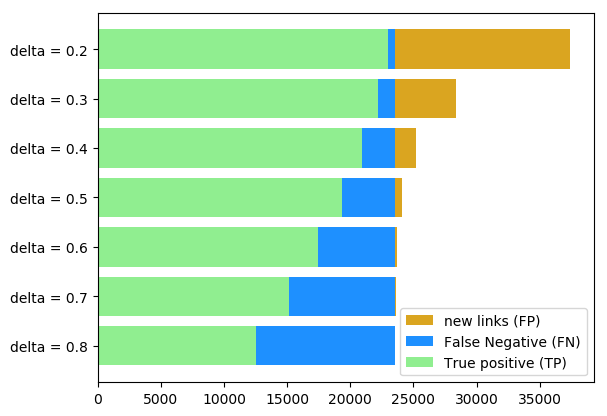

In [23]:
R12 = sparse.load_npz('./tmp/R12.npz').toarray()
R12_found = np.load('./tmp/R12_final.npy')

delta = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
n, m = R12_found.shape
R12_delta = np.zeros((n,m))
T = [np.sum(R12)]*len(delta)
TP, FP = [], []

plt.rcdefaults()
fig, ax = plt.subplots()
for l in range(len(delta)):
    for i in range(n):
        for j in range(m):
            R12_delta[i,j] = R12_found[i,j] > delta[l]

    R12_TP = np.multiply(R12_delta, R12)
    TP.append(np.sum(R12_TP))
    FP.append(np.sum(R12_delta) - np.sum(R12_TP) + T[0])

y_pos = np.arange(len(delta))

ax.barh(y_pos, FP,label = 'new links (FP)', color = 'goldenrod')
ax.barh(y_pos, T, label = 'False Negative (FN)', color = 'dodgerblue')
ax.barh(y_pos, TP, label = 'True positive (TP)', color = 'lightgreen')

delta_label = ['delta = {}'.format(l) for l in delta]
ax.set_yticks(y_pos)
ax.set_yticklabels(delta_label)
ax.invert_yaxis()  # labels read top-to-bottom

plt.legend()
plt.show()

For a given threshold $\delta$, this data can also be plot per label.

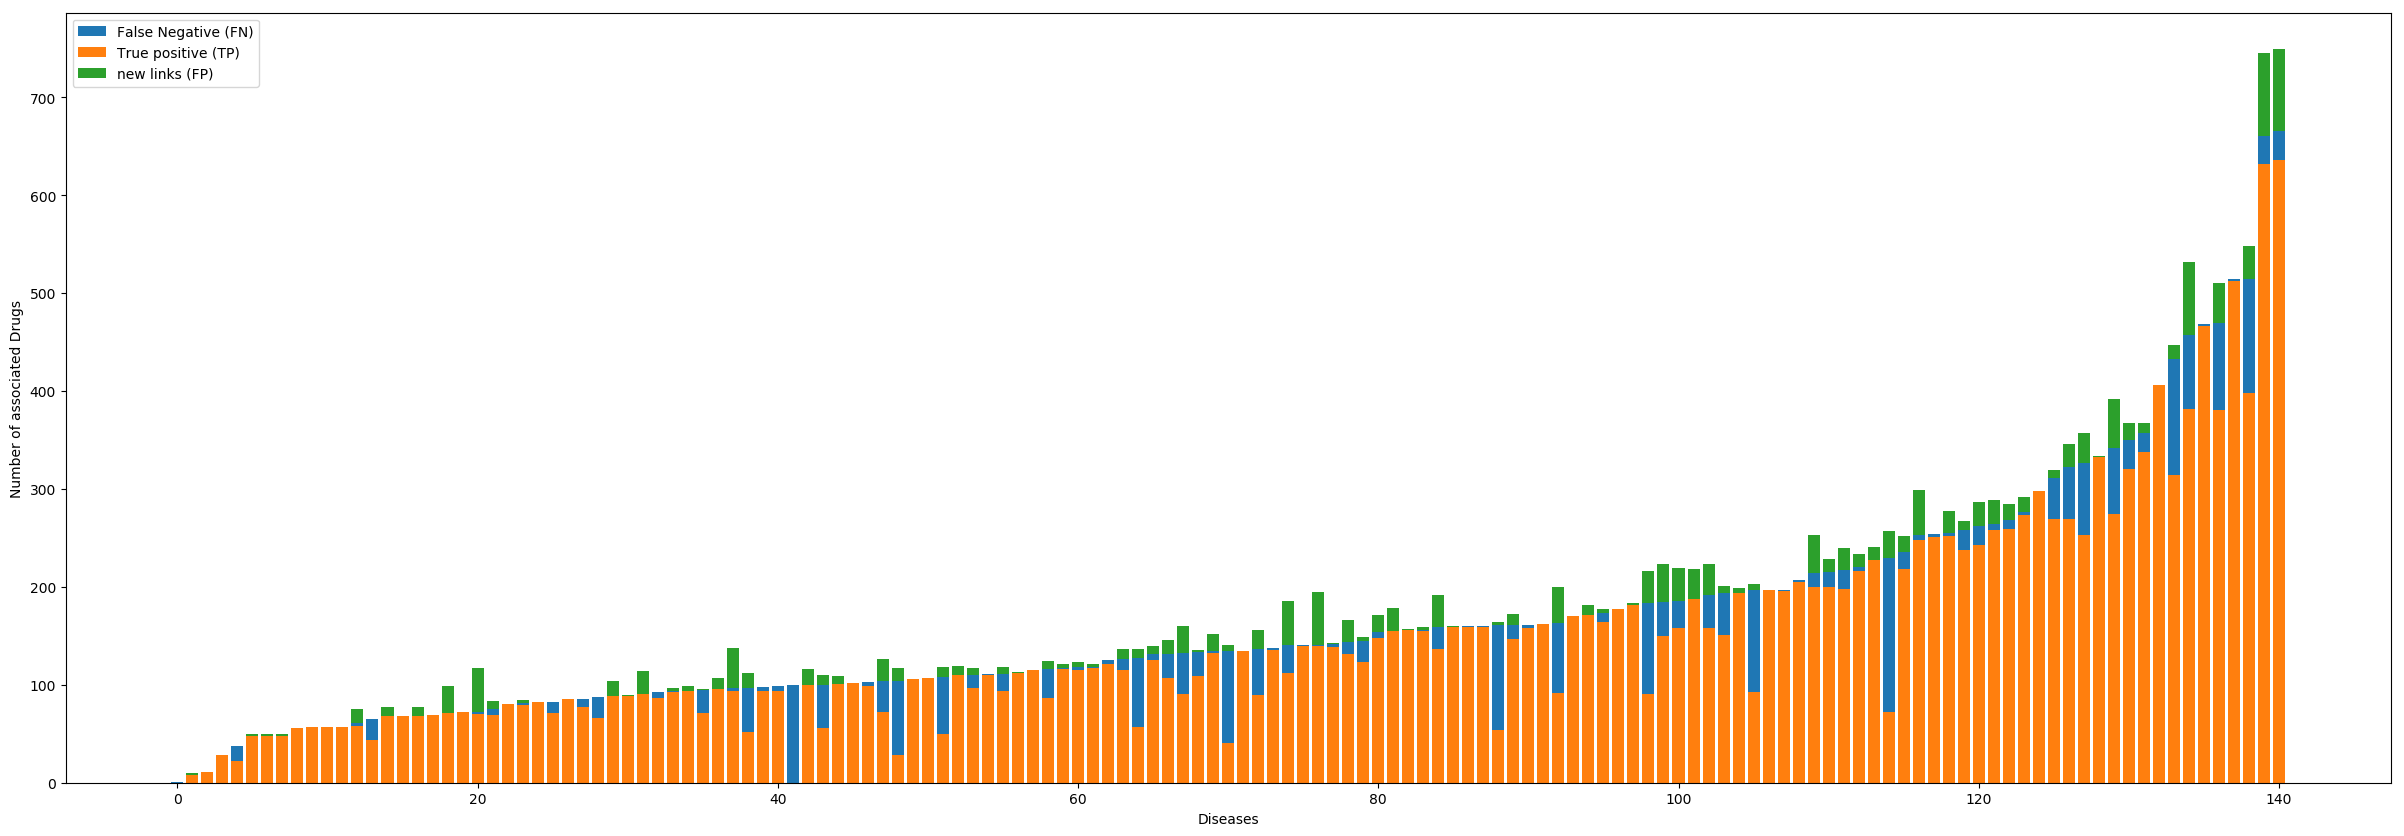

In [24]:
R12 = sparse.load_npz('./tmp/R12.npz').toarray()
R12_found = np.load('./tmp/R12_final.npy')
plt.rcParams["figure.figsize"] = (30,10)

delta = 0.4
n, m = R12_found.shape

for i in range(n):
    for j in range(m):
        R12_found[i,j] = R12_found[i,j] > delta

R12_TP = np.multiply(R12_found, R12)

bar = np.sum(R12, axis=1)
Index = np.argsort(bar)

bar.sort()
bar_TP = []
bar_new = []

X = np.arange(len(bar))

for i in range(len(Index)):
    bar_TP.append(np.sum(R12_TP[Index[i]]))
    bar_new.append(np.sum(R12_found[Index[i]]) - np.sum(R12_TP[Index[i]]))
    
plt.rcParams["figure.figsize"] = (30,10)
plt.bar(X, bar, label = 'False Negative (FN)')
plt.bar(X, bar_TP, label = 'True positive (TP)')
plt.bar(X, bar_new, bottom=bar, label = 'new links (FP)')
plt.legend()
plt.xlabel('Diseases')
plt.ylabel('Number of associated Drugs')
plt.show()

This plot is particularly interesting as it shows that, *a priori*, it is hard to find a correlation between:
- The number of original links and the number of new links found
- The proportion of TP (**<span style="color:orange">in orange</span>**) and the proportion of FP (**<span style="color:green">in green</span>**).